In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math
import joblib
import pickle

In [2]:
excel_file_path = '../budgetusd.xlsx'
sheet_name = "F&B Revenue"
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
# Load the Excel file into a pandas DataFrame


#### Clean, Transform & Load Data

In [3]:
import pandas as pd
import math

# This function will remove decimal points
def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

# Load your DataFrame (assuming you've already loaded it)
# df = pd.read_excel('budgetusd.xlsx', sheet_name='Rooms Revenue', engine='openpyxl')

# Apply the 'round_up_numeric' function to all columns
df = df.applymap(round_up_numeric)

# Define replacements for multiple columns
column_replacements = {
    'Local Rainy Season': {"No": 0, "Medium": 1, "Yes": 2},
    'Seasonality': {"Low": 0, "Medium": 1, "High": 2}
}

# Map values in the specified columns
for col, replacements in column_replacements.items():
    df[col] = df[col].replace(replacements)

# Assuming your dataset is loaded into a DataFrame named 'df'
# Clean the column by removing non-numeric characters and converting to float
df['Percentage F&B Occ %'] = pd.to_numeric(df['Percentage F&B Occ %'], errors='coerce')

# Check the data types after conversion
print(df.dtypes)

# Now, the "Percentage F&B Occ %" column should be of data type float64


# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Now, you can run this entire cell to execute all the operations.

df


Date                       object
Percentage Rooms Occ %    float64
Holidays Local            float64
Seasonality                 int64
Holidays North            float64
Local Rainy Season          int64
Marketing                 float64
Number of Rooms           float64
Rooms Revenue             float64
Percentage F&B Occ %      float64
Average Price F&B         float64
F&B Revenue               float64
dtype: object


,Percentage Rooms Occ %,Holidays Local,Seasonality,Holidays North,Local Rainy Season,Marketing,Number of Rooms,Rooms Revenue,Percentage F&B Occ %,Average Price F&B,F&B Revenue
Date,,,,,,,,,,,
2023-10-01,0.00,0.0,0,0.0,2,10.00,9.0,0.00,0.10,16.0,1468.03
2023-11-01,0.00,0.0,0,0.0,0,10.00,9.0,0.00,0.10,16.0,1468.03
2023-12-01,0.00,0.0,0,0.0,0,10.00,9.0,0.00,0.10,16.0,1468.03
2022-01-01,0.61,5.0,2,7.0,0,62.12,9.0,13136.89,0.80,16.0,11744.20
2022-02-01,0.62,1.0,2,0.0,0,62.12,9.0,11430.53,0.60,16.0,9433.34
2022-03-01,0.39,0.0,2,0.0,0,99.31,9.0,9742.62,0.70,16.0,8833.09
2022-04-01,0.70,6.0,2,0.0,0,246.06,9.0,15043.81,0.80,16.0,18834.59
2022-05-01,0.47,1.0,0,0.0,1,144.93,9.0,8546.17,0.50,16.0,9258.35
2022-06-01,0.33,0.0,0,0.0,1,118.46,9.0,7171.42,0.20,16.0,4703.32


In [4]:
duplicate_cols = df.columns[df.columns.duplicated()]
print("Duplicate Columns:", duplicate_cols)

Duplicate Columns: Index([], dtype='object')


In [5]:
df.isnull().sum()

Percentage Rooms Occ %    0
Holidays Local            0
Seasonality               0
Holidays North            0
Local Rainy Season        0
Marketing                 0
Number of Rooms           0
Rooms Revenue             0
Percentage F&B Occ %      0
Average Price F&B         0
F&B Revenue               0
dtype: int64

#### Percentage F&B Occ % Model

In [6]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
                                        df.drop(['F&B Revenue', 'Percentage F&B Occ %'], axis=1),
                                        df['Percentage F&B Occ %'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train_1.shape, y_train_1.shape,"\n* Test set:", X_test_1.shape, y_test_1.shape)         



* Train set: (40, 9) (40,) 
* Test set: (11, 9) (11,)


In [7]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [8]:
pipeline_1 = pipeline_random_forest_reg()
pipeline_1.fit(X_train_1, y_train_1)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [9]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.946
Mean Absolute Error: 0.038
Mean Squared Error: 0.002
Root Mean Squared Error: 0.049


* Test Set
R2 Score: 0.836
Mean Absolute Error: 0.074
Mean Squared Error: 0.008
Root Mean Squared Error: 0.09




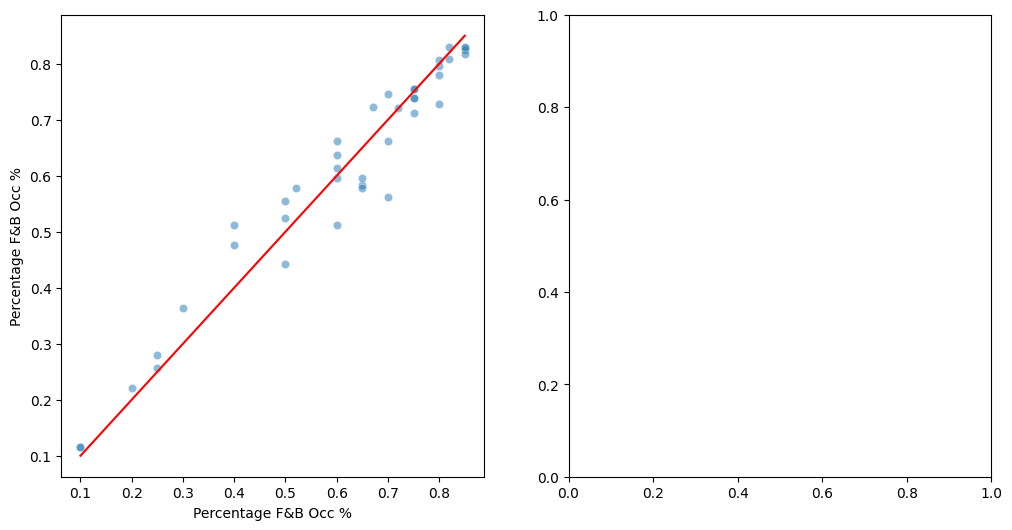

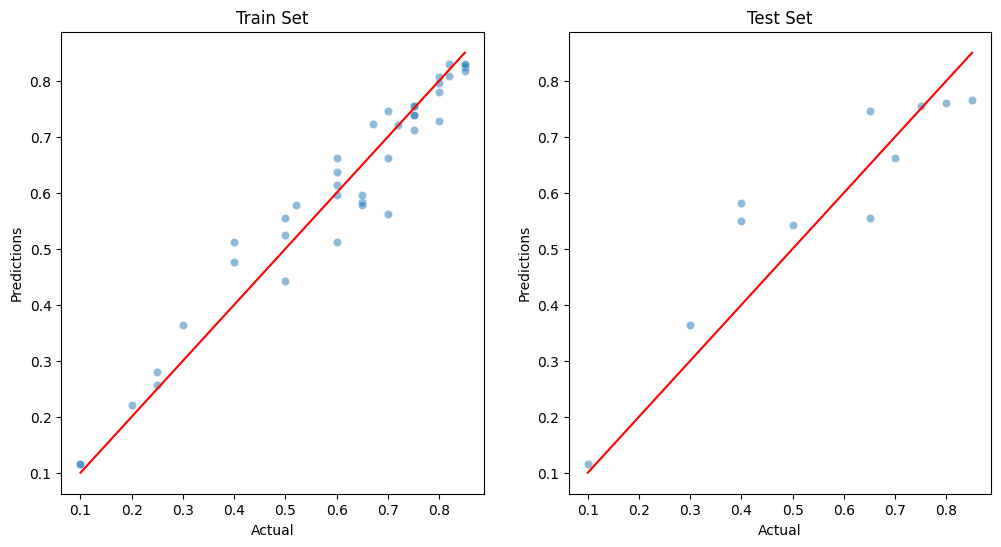

In [10]:
regression_performance(X_train_1, y_train_1, X_test_1, y_test_1, pipeline_1)
regression_evaluation_plots(X_train_1, y_train_1, X_test_1, y_test_1, pipeline_1, alpha_scatter=0.5)

In [11]:
# Get the feature selection model from the pipeline
feature_selection_model = pipeline_1.named_steps["feature_selection"]

# Get the feature selection mask
feature_mask = feature_selection_model.get_support()

# Get the original feature names
selected_feature_names = X_train_1.columns[feature_mask]

# Print the selected feature names
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['Percentage Rooms Occ %', 'Rooms Revenue'], dtype='object')


In [12]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

* These are the 2 most important features in descending order. The model was trained on them:
['Rooms Revenue', 'Percentage Rooms Occ %']


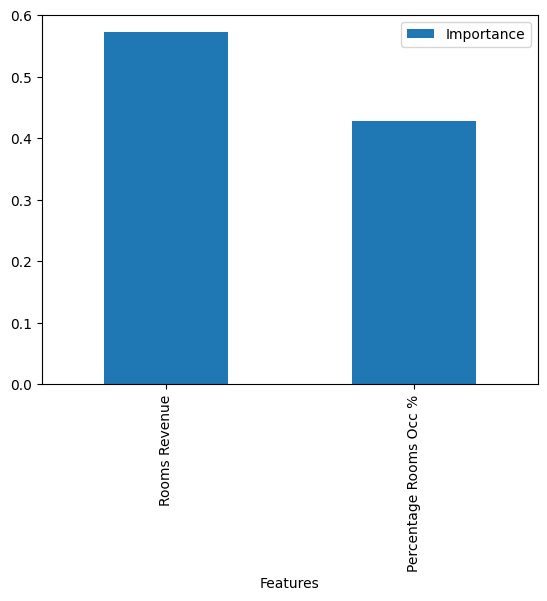

In [13]:
best_features = feature_importance_tree_based_models(model = pipeline_1['model'],
                                     columns = X_train_1.columns[pipeline_1['feature_selection'].get_support()])

In [14]:
relevant_features_1 = ['Rooms Revenue', 'Holidays Local', 'Percentage Rooms Occ %', 'Seasonality', 'Local Rainy Season', 'Percentage F&B Occ %']
df_relevant_1 = df[relevant_features_1]

In [15]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
                                        df_relevant_1.drop(['Percentage F&B Occ %'], axis=1),
                                        df_relevant_1['Percentage F&B Occ %'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train_1.shape, y_train_1.shape,"\n* Test set:", X_test_1.shape, y_test_1.shape)         



* Train set: (40, 5) (40,) 
* Test set: (11, 5) (11,)


In [16]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [17]:
pipeline_1 = pipeline_random_forest_reg()
pipeline_1.fit(X_train_1, y_train_1)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.951
Mean Absolute Error: 0.034
Mean Squared Error: 0.002
Root Mean Squared Error: 0.047


* Test Set
R2 Score: 0.859
Mean Absolute Error: 0.059
Mean Squared Error: 0.007
Root Mean Squared Error: 0.084




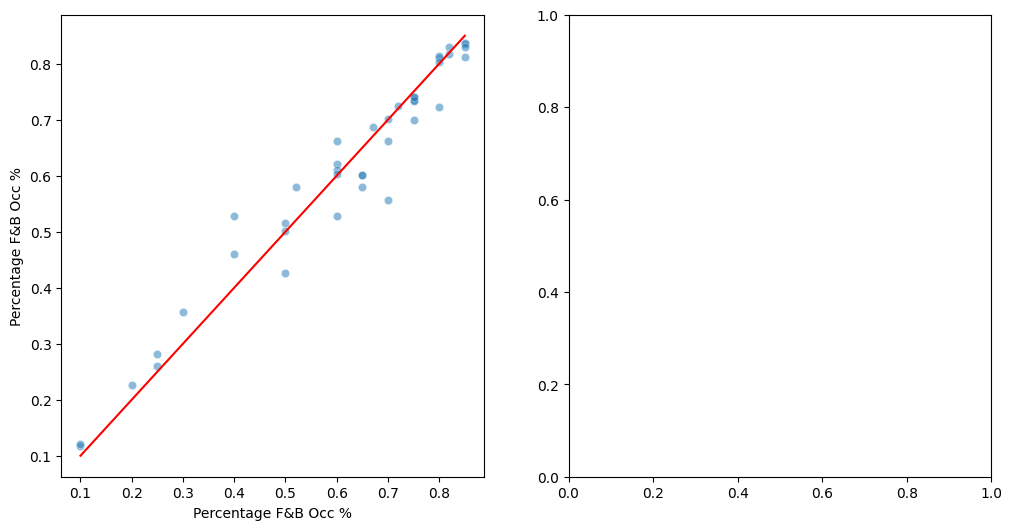

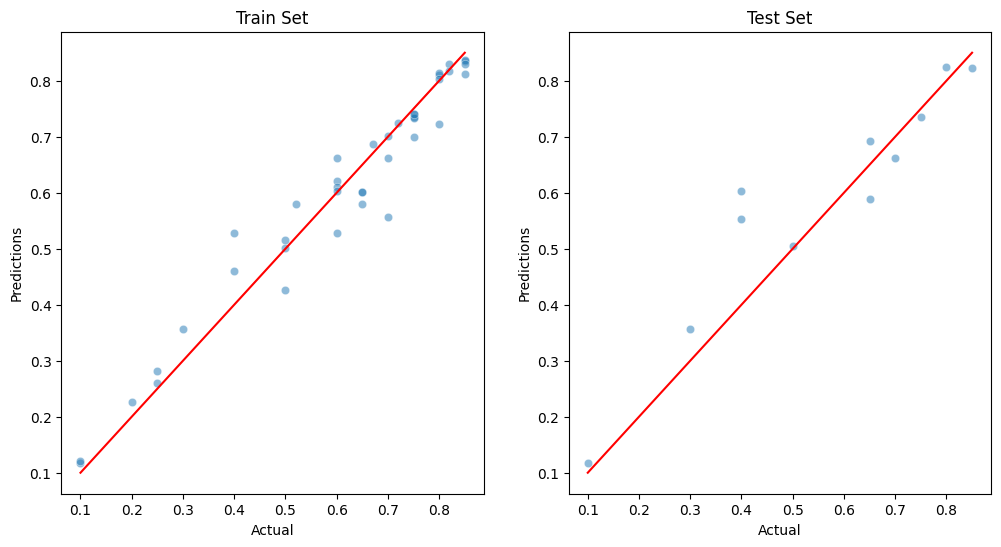

In [19]:
regression_performance(X_train_1, y_train_1, X_test_1, y_test_1, pipeline_1)
regression_evaluation_plots(X_train_1, y_train_1, X_test_1, y_test_1, pipeline_1, alpha_scatter=0.5)

In [20]:
model = 'f&b_occ_model.pkl'
joblib.dump(pipeline_1, model)

['f&b_occ_model.pkl']

In [21]:
loaded_model_1 = joblib.load('f&b_occ_model.pkl')


In [22]:
# Create a DataFrame with the feature values for prediction
new_data = pd.DataFrame({
    'Rooms Revenue': [20000],
    'Holidays Local': [5],  
    'Percentage Rooms Occ %': [0.75],
    'Seasonality': [2],
    'Local Rainy Season': [0]
})

## Percentage Rooms Occ %	Holidays Local	Seasonality	Holidays North	Local Rainy Season	Marketing	Number of Rooms	Rooms Revenue	Percentage F&B Occ %	Average Price F&B	F&B Revenue
											

# Now you have new_data with the features filled in.

# Use the model to make predictions
predicted_fb_occupancy = loaded_model_1.predict(new_data)

# Print the predicted F&B revenue
print(f"Predicted F&B Occupancy: %{predicted_fb_occupancy}")

Predicted F&B Occupancy: %[0.82601667]


#### F&B Revenue Model

#### Split Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['F&B Revenue'], axis=1),
                                        df['F&B Revenue'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (40, 10) (40,) 
* Test set: (11, 10) (11,)


In [24]:
pipeline_1 = pipeline_random_forest_reg()
pipeline_1.fit(X_train_1, y_train_1)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

### GradientCV Hyperparameters
    

In [25]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
    ])
    return pipeline

# Define the parameter grid with the correct parameter name
param_grid = {"model__n_estimators": [10, 20]}

# Create the pipeline
pipeline = pipeline_random_forest_reg()

# Create the GridSearchCV object
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    cv=2,
                    n_jobs=-2,
                    verbose=3,
                    scoring='r2')

# Fit the GridSearchCV to perform hyperparameter tuning
grid.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END ............model__n_estimators=10;, score=0.883 total time=   0.2s
[CV 1/2] END ............model__n_estimators=20;, score=0.878 total time=   0.2s
[CV 2/2] END ............model__n_estimators=10;, score=0.590 total time=   0.2s
[CV 2/2] END ............model__n_estimators=20;, score=0.604 total time=   0.2s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                                       ('model',
                                        RandomForestRegressor(random_state=101))]),
             n_jobs=-2, param_grid={'model__n_estimators': [10, 20]},
             scoring='r2', verbose=3)

In [26]:
(pd.DataFrame(grid.cv_results_)
.sort_values(by="mean_test_score", ascending=False)
.filter(['params', 'mean_test_score'])
.values
)

array([[{'model__n_estimators': 20}, 0.740522963760661],
       [{'model__n_estimators': 10}, 0.7364498101458757]], dtype=object)

In [27]:
pipeline = grid.best_estimator_
pipeline

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model',
                 RandomForestRegressor(n_estimators=20, random_state=101))])

#### Performance of Model GradientCV

In [28]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.949
Mean Absolute Error: 657.287
Mean Squared Error: 827033.18
Root Mean Squared Error: 909.414


* Test Set
R2 Score: 0.751
Mean Absolute Error: 1519.488
Mean Squared Error: 3431743.684
Root Mean Squared Error: 1852.497




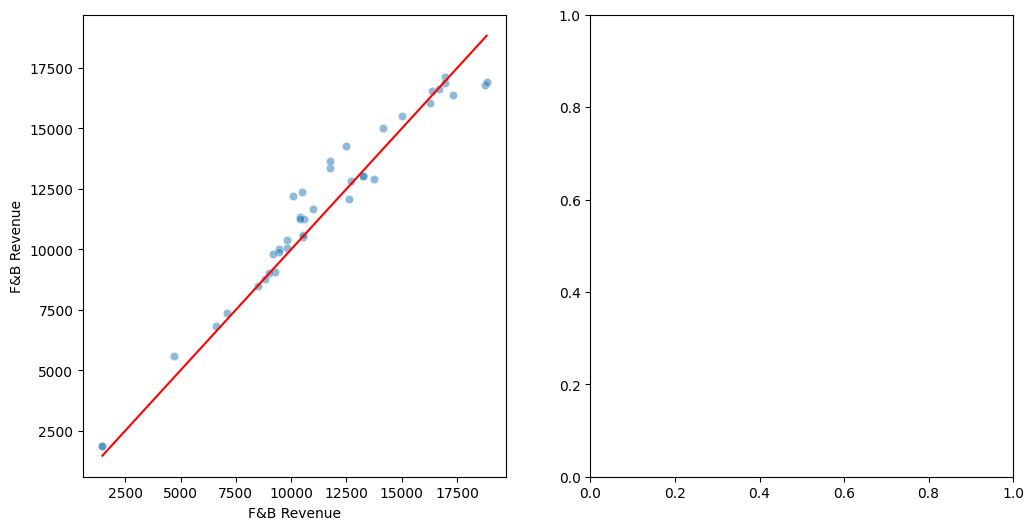

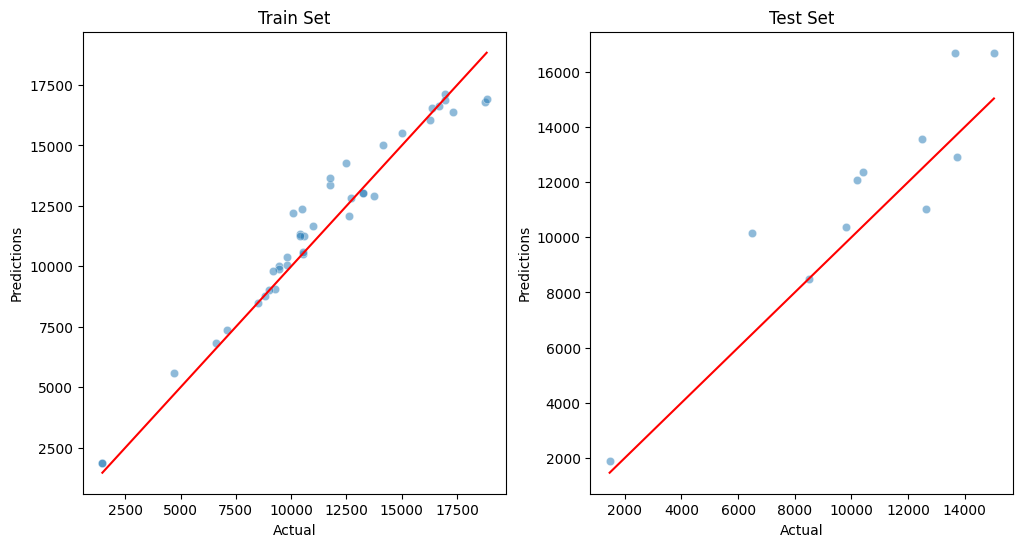

In [29]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

#### Regressor

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['F&B Revenue'], axis=1),
                                        df['F&B Revenue'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (40, 10) (40,) 
* Test set: (11, 10) (11,)


In [31]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [32]:
pipeline_rf = pipeline_random_forest_reg()
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [33]:
from sklearn.feature_selection import SelectFromModel

# Create the pipeline
pipeline_rf = pipeline_random_forest_reg()

# Fit your pipeline with your data
pipeline_rf.fit(X_train, y_train)  # Replace X_train and y_train with your training data

# Get the feature selection model from the pipeline
feature_selection_model = pipeline_rf.named_steps["feature_selection"]

# Get the feature selection mask
feature_mask = feature_selection_model.get_support()

# Get the original feature names
selected_feature_names = X_train.columns[feature_mask]

# Print the selected feature names
print("Selected Feature Names:", selected_feature_names)


Selected Feature Names: Index(['Percentage Rooms Occ %', 'Rooms Revenue', 'Percentage F&B Occ %'], dtype='object')


In [34]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

* These are the 3 most important features in descending order. The model was trained on them:
['Rooms Revenue', 'Percentage F&B Occ %', 'Percentage Rooms Occ %']


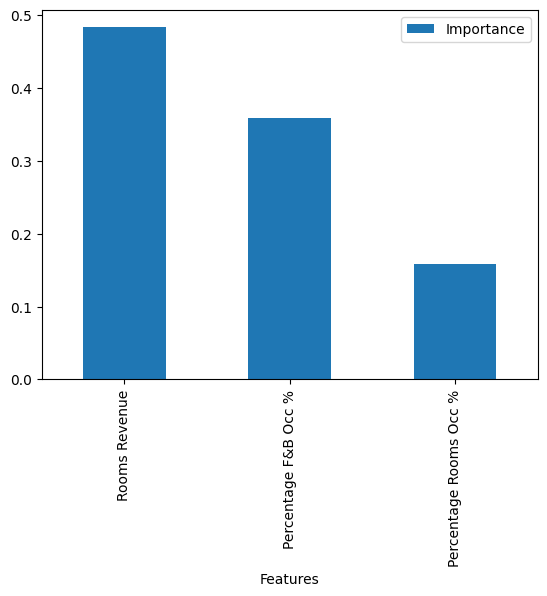

In [35]:
best_features = feature_importance_tree_based_models(model = pipeline_rf['model'],
                                     columns = X_train.columns[pipeline_rf['feature_selection'].get_support()])

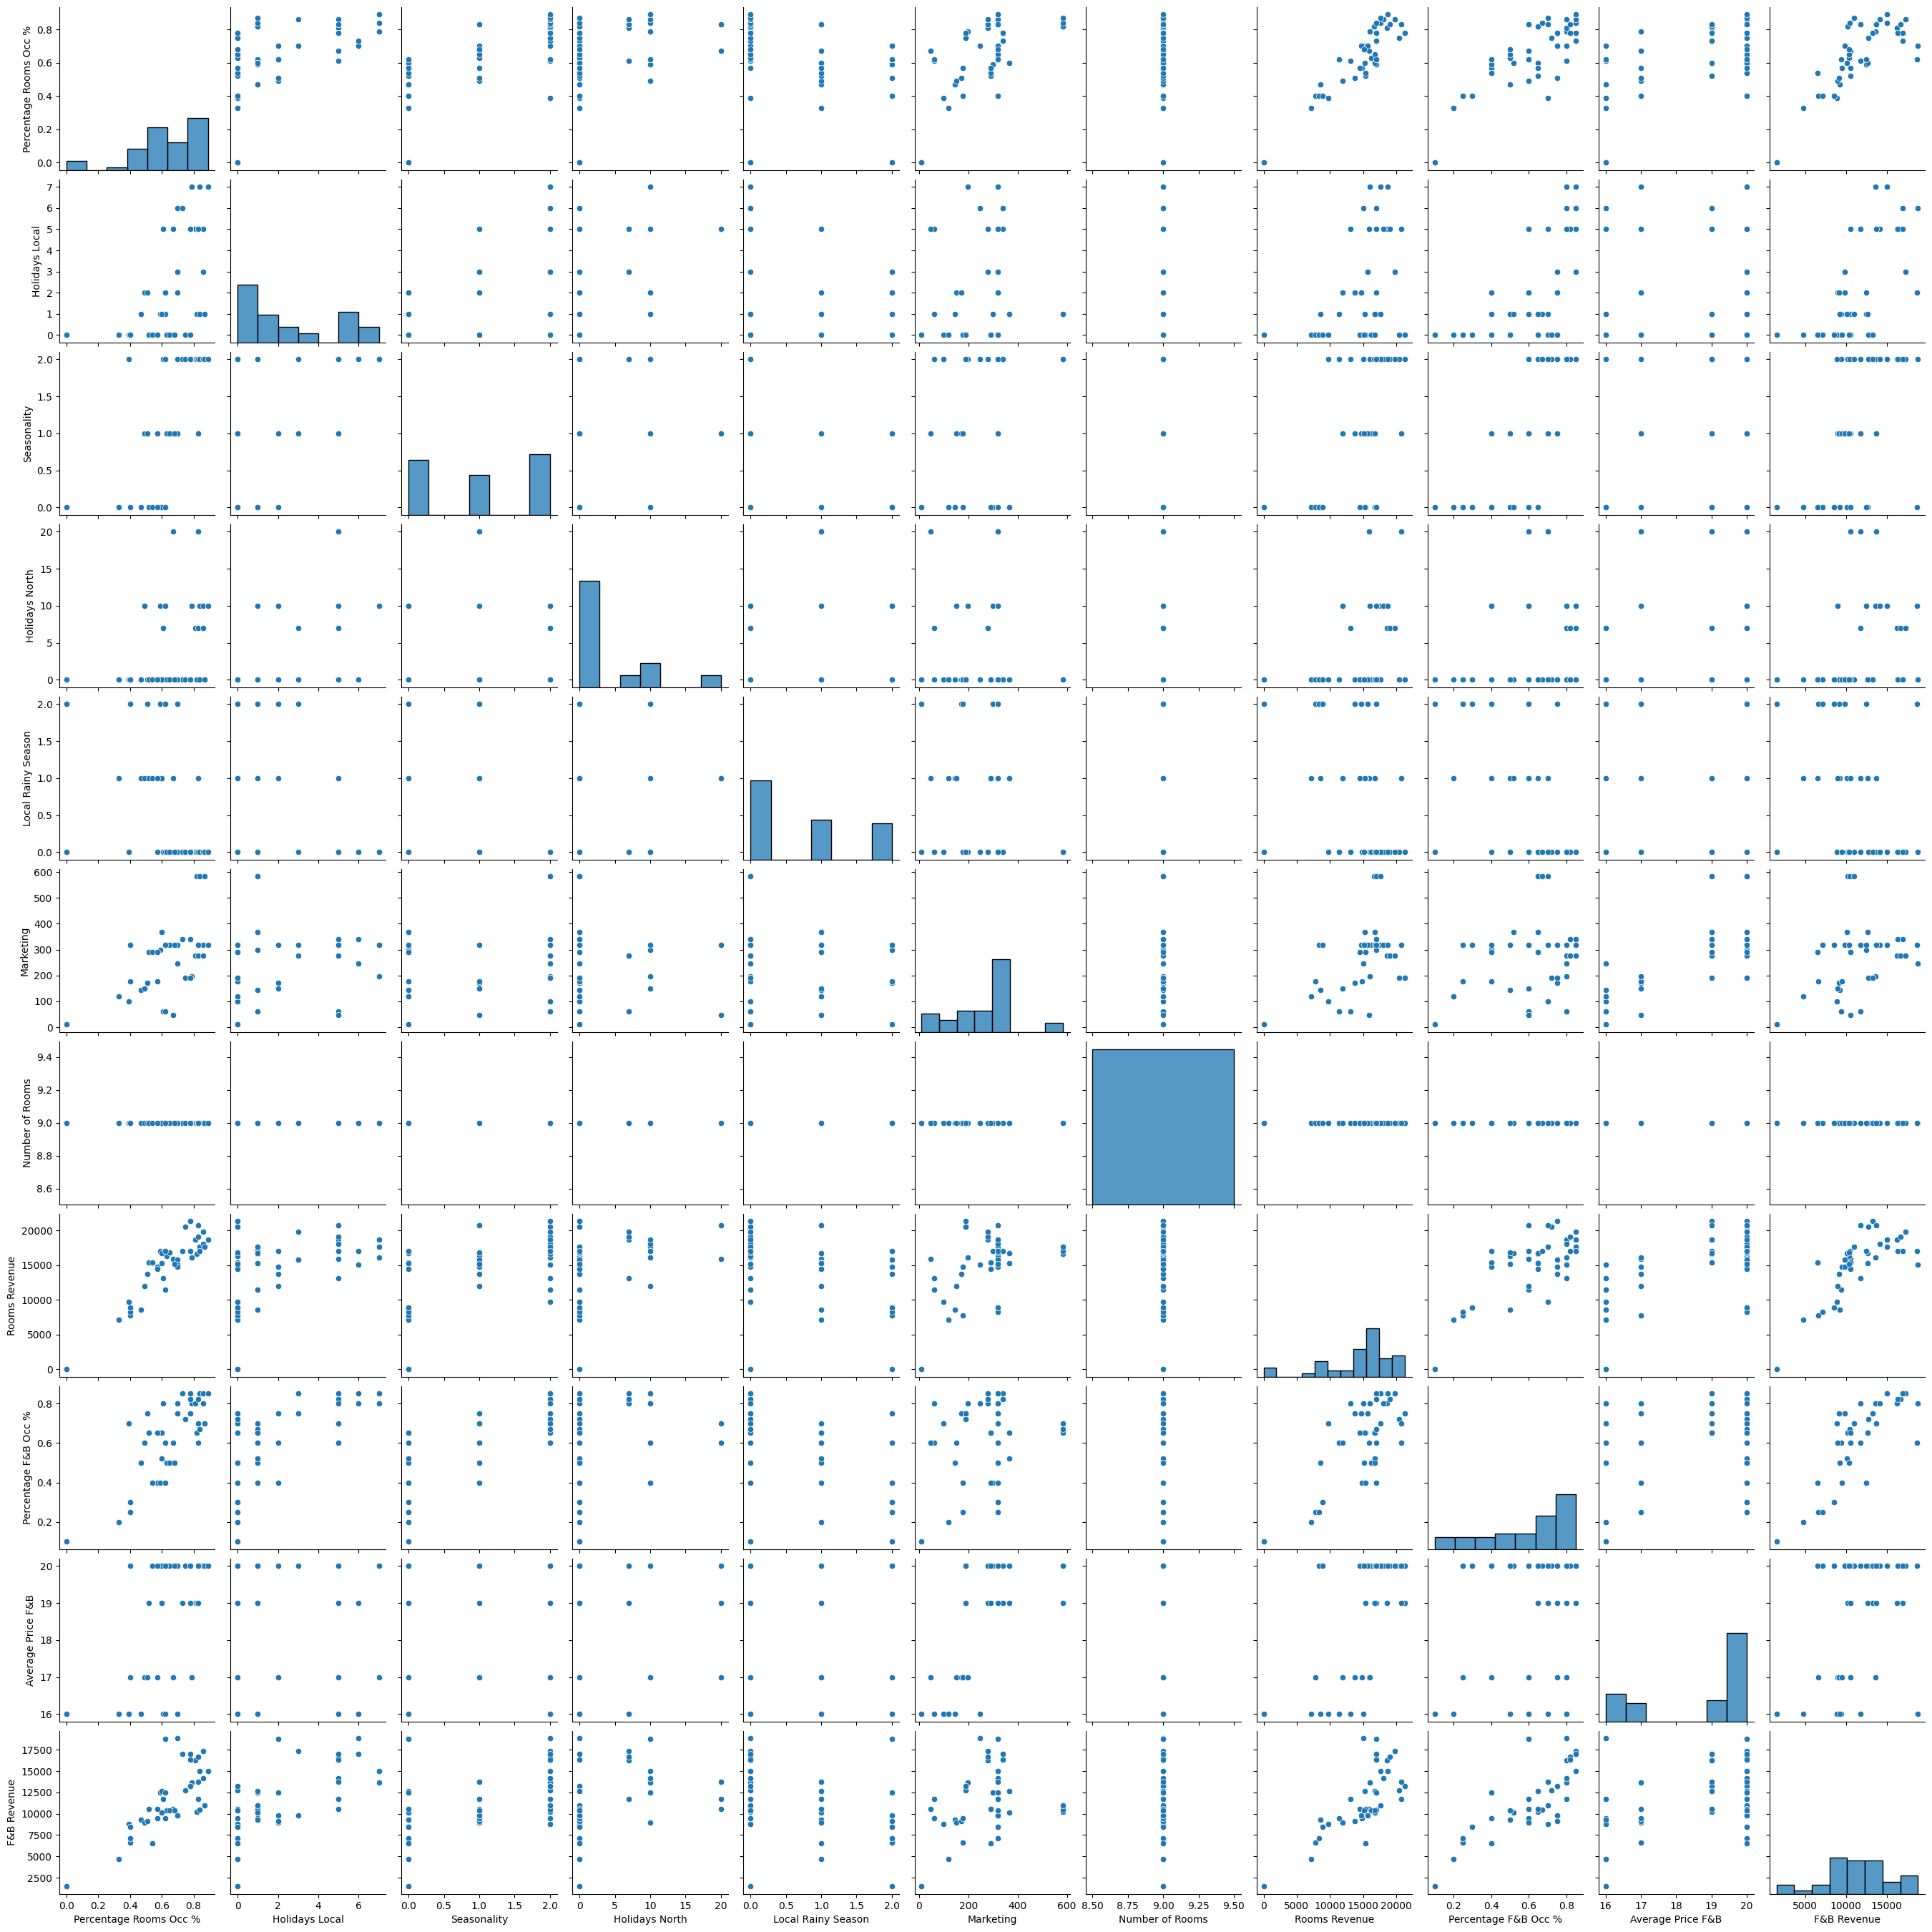

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


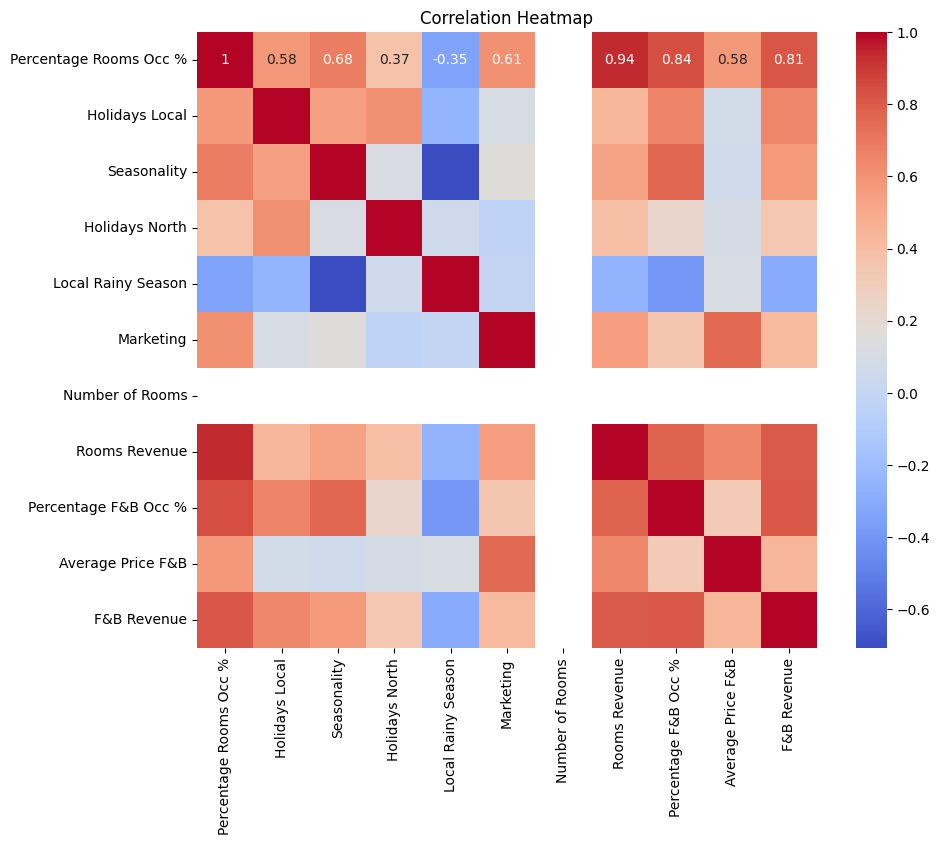

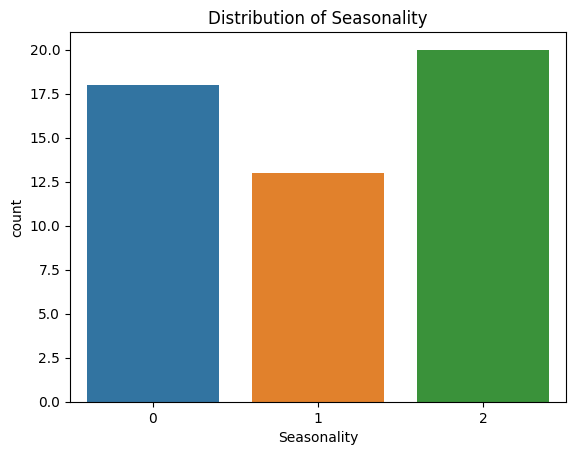

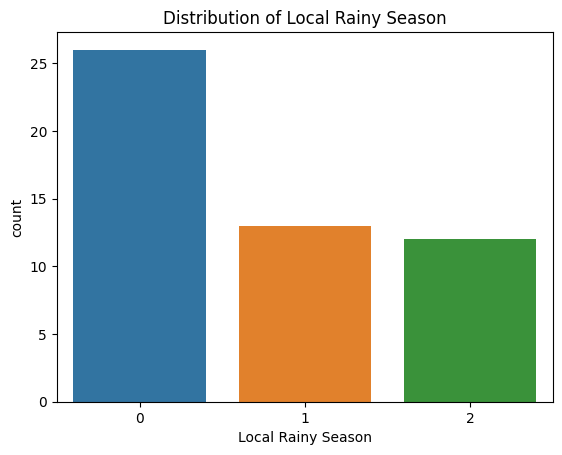

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables 	
sns.pairplot(df, vars=['Percentage Rooms Occ %', 'Holidays Local', 'Seasonality', 'Holidays North',	'Local Rainy Season', 'Marketing', 'Number of Rooms',
'Rooms Revenue', 'Percentage F&B Occ %', 'Average Price F&B', 'F&B Revenue'])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Bar plots for categorical variables
categorical_cols = ['Seasonality', 'Local Rainy Season']
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()


In [37]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline_rf):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline_rf)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline_rf)

def regression_evaluation(X, y, pipeline_rf):
    prediction = pipeline_rf.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_rf, alpha_scatter=0.5):
    pred_train = pipeline_rf.predict(X_train)
    pred_test = pipeline_rf.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.96
Mean Absolute Error: 559.403
Mean Squared Error: 654521.145
Root Mean Squared Error: 809.025


* Test Set
R2 Score: 0.787
Mean Absolute Error: 1397.045
Mean Squared Error: 2931711.001
Root Mean Squared Error: 1712.224




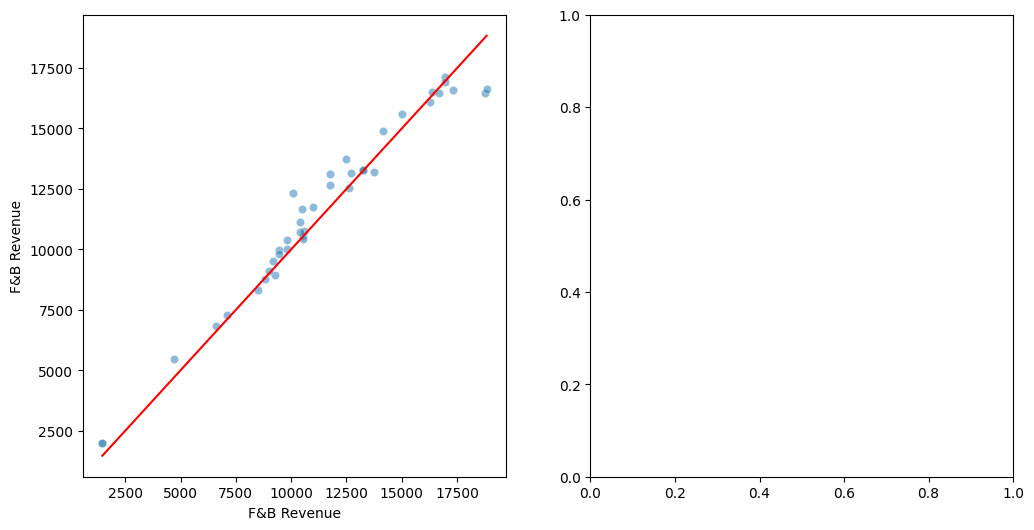

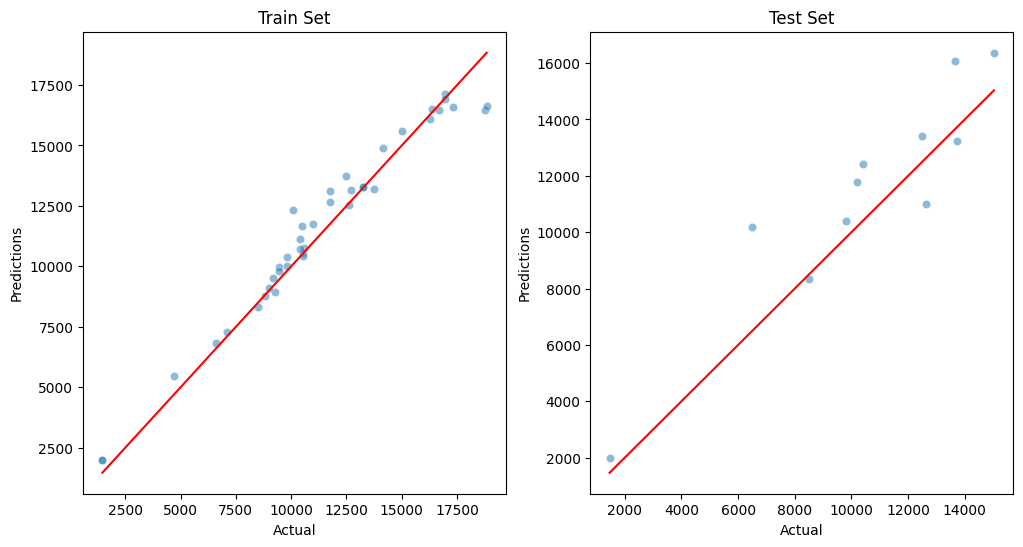

In [38]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_rf)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_rf, alpha_scatter=0.5)

In [39]:
relevant_features = ['Rooms Revenue', 'Seasonality', 'Holidays Local', 'Percentage Rooms Occ %', 'Percentage F&B Occ %', 'F&B Revenue']
df_relevant = df[relevant_features]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_relevant.drop(['F&B Revenue'], axis=1),
                                        df_relevant['F&B Revenue'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (40, 5) (40,) 
* Test set: (11, 5) (11,)


In [41]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        #("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [42]:
pipeline_ = pipeline_random_forest_reg()
pipeline_.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [43]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline_):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline_)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline_)

def regression_evaluation(X, y, pipeline_):
    prediction = pipeline_.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_, alpha_scatter=0.5):
    pred_train = pipeline_.predict(X_train)
    pred_test = pipeline_.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.964
Mean Absolute Error: 553.451
Mean Squared Error: 588924.729
Root Mean Squared Error: 767.414


* Test Set
R2 Score: 0.828
Mean Absolute Error: 1219.316
Mean Squared Error: 2366472.62
Root Mean Squared Error: 1538.334




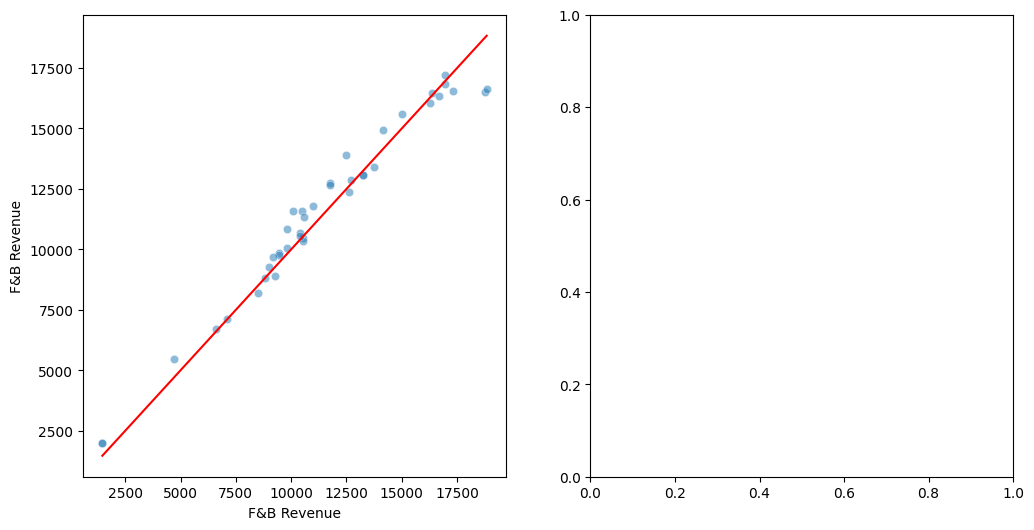

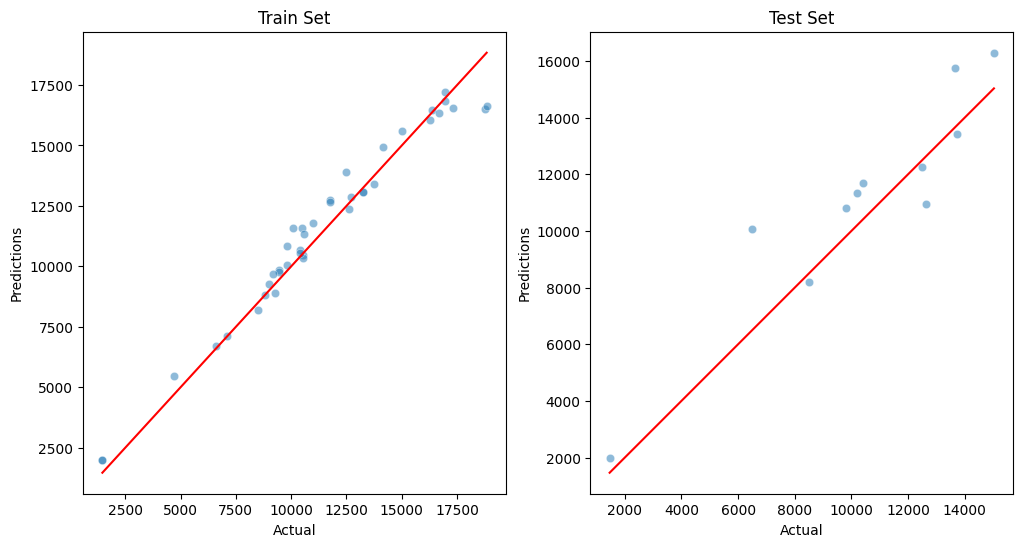

In [44]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_, alpha_scatter=0.5)

In [45]:
model = 'f&b_revenue_model.pkl'
joblib.dump(pipeline_, model)

['f&b_revenue_model.pkl']

In [46]:
loaded_model = joblib.load('f&b_revenue_model.pkl')

In [47]:
# Create a DataFrame with the feature values for prediction
new_data = pd.DataFrame({
    'Rooms Revenue': [00],
    'Seasonality':[0],
    'Holidays Local':[0],
    'Percentage Rooms Occ %': [0.0],
    'Percentage F&B Occ %': [0.0]
})


## Percentage Rooms Occ %	Holidays Local	Seasonality	Holidays North	Local Rainy Season	Marketing	Number of Rooms	Rooms Revenue	Percentage F&B Occ %	Average Price F&B	F&B Revenue
											

# Now you have new_data with the features filled in.

# Use the model to make predictions
predicted_fnb_revenue = loaded_model.predict(new_data)

# Print the predicted F&B revenue
print(f"Predicted F&B Revenue: ${predicted_fnb_revenue}")


Predicted F&B Revenue: $[1975.6113]
